# Advanced data reduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os, glob
from redcross import Datacube, read_harpsn, read_giano, Pipeline

## Reading instrument files
Let's read the instrument's pipeline FITS files for each spectrum and create a `Datacube` instance with the correct formatting. 

### Example 1: HARPS-N 
In this example we place HARPS-N `e2ds` files in one folder `data_dir`.
HARPS-N is an ultra-stabilised spectrograph placed at the 3.6m-TNG telescope with a resolution of **R ~ 115,000**. It works in the **optical range from 400 to 690 nm**.

In [2]:
data_dir = '../../../../wasp189/data/e2ds/night1'
files = sorted(glob.glob(os.path.join(data_dir, '*.fits'))) # IMPORTANT: sort the files
print('{:} files found!'.format(len(files)))

247 files found!


For HARPS-N, we use the in-built function `read_harpsn`. The function reads all the files and reshapes them to store the data for each order with all frames.
At this stage you may want to define your own function to 
read the *wavelength*, *flux* and the *header* of each frame. The header must be a dictionary and can be passed as a kwarg argument i.e. `dc = Datacube(**header)`. The header keys will automatically be stored as attributes.

In [3]:
dc = read_harpsn(files)
print('\n{:} orders, {:} files, {:} pixel channels\n'.format(*dc.shape))

---> 246 HARPN.2019-04-14T05-32-17.209_e2ds_A.fits
69 orders, 247 files, 4096 pixel channels



### Wavelength solution
Most instrument's pipelines provide a wavelength solution (WS) stored as a vector or as a polynomial in the FITS file. For this example, we take the **WS of each order as the time-average of all the frames** for that order. This works well for *ultra*-stabilised instruments but additional steps to refine the WS might be necessary in some cases.

In [4]:
print('Original wavelength vector shape = {:}'.format(dc.wlt.shape))
dc.wlt = np.median(dc.wlt, axis=1)
print('NEW wavelength vector shape = {:}'.format(dc.wlt.shape))

Original wavelength vector shape = (69, 247, 4096)
NEW wavelength vector shape = (69, 4096)


### Header parameters
The header parameters are optional but it is recommended to pass them when creating the `datacube` instance. Some tools like `airmass_detrend` will only work with required header parameters (airmass).

dict_keys(['flux', 'wlt', 'flux_err', 'night', 'airmass', 'MJD', 'BERV', 'RA_DEG', 'DEC_DEG', 'DATE'])


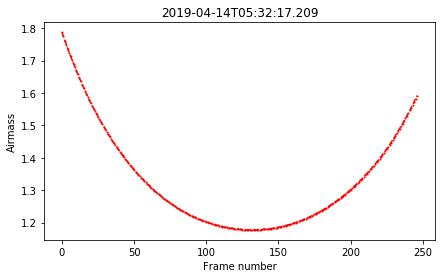

In [5]:
print(vars(dc).keys())
fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(dc.airmass, '--or', ms=1.)
ax.set(title=dc.DATE, xlabel='Frame number', ylabel='Airmass')
plt.show()

### Reduction pipeline for a single-order
We use the `Pipeline` object to define a set of reduction steps and apply them to every order. First, we play around with the routine by displaying the step-by-step process for a given order. Steps can also be added individually and arguments to the functions can be passed as dictionaries.

/usr/lib/python3/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


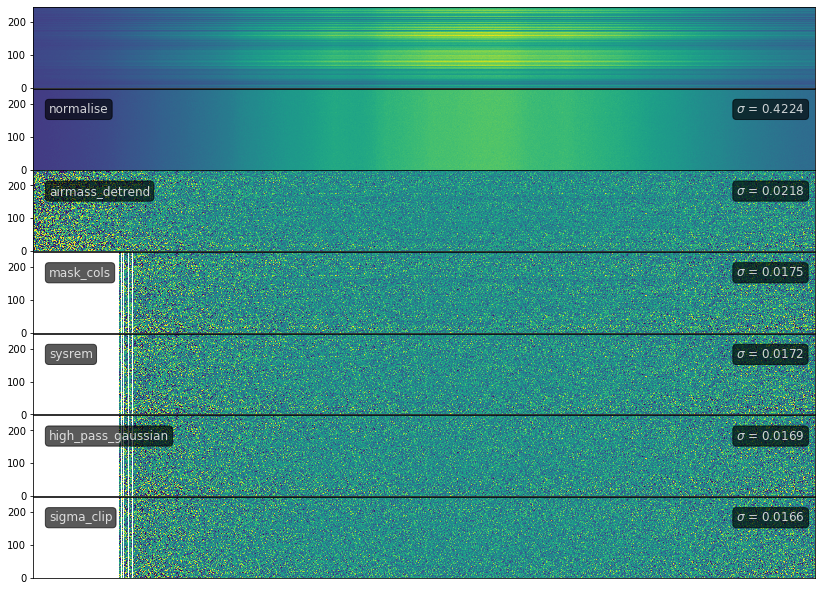

In [6]:
steps = ['normalise','airmass_detrend']
pipeline = Pipeline(steps)

# Add functions with arguments
pipeline.add('mask_cols', {'sigma':1.2, 'mode':'flux'}) 
pipeline.add('sysrem', {'n':3})
pipeline.add('high_pass_gaussian', {'window':15})
pipeline.add('sigma_clip', {'sigma':3}) 

n = len(steps)+1
fig, ax = plt.subplots(n, figsize=(14, n*1.5))
plt.subplots_adjust(hspace=0.01)
[ax[k].set_xticks([]) for k in range(n)]

# Call the Pipeline object to a given order
# pass `ax` to display every step (with len(ax) = len(steps)+1))
pipeline.reduce(dc.order(26), ax=ax)

### Example 2: GIANO 
GIANO is a high-resolution **R ~ 50,000** infra-red spectrograph covering the range of **950 to 2450 nm**. It can function jointly with HARPS-N in the GIARPS mode. In this example we work with data from the same observing night (and same target). The calibration pipeline for GIANO is different than HARPS-N. The quality of the data and the presence of telluric lines makes the reduction of GIANO more challenging.

In [7]:
data_dir = '../../../../wasp189/data/giano/night1/posB'
files = sorted(glob.glob(os.path.join(data_dir, '*ms1d.fits'))) # IMPORTANT: sort the files
print('{:} files found!'.format(len(files)))
dc = read_giano(files)
print('\n{:} orders, {:} files, {:} pixel channels\n'.format(*dc.shape))

84 files found!
---> 83 GIANO-B.2019-04-14T05-16-51.000_B_ms1d.fits
50 orders, 84 files, 2048 pixel channels



As with HARPS-N, we define the wavelength solution for each order as the time-average. Note that GIANO is known to have *unstable* wavelength calibrations over the duration of an observing night (see Brogi 2018). Further calibrations might be necessary, for the purposes of this example we can work with the time-average as a first-order estimate.

In [8]:
dc.wlt = np.median(dc.wlt, axis=1)

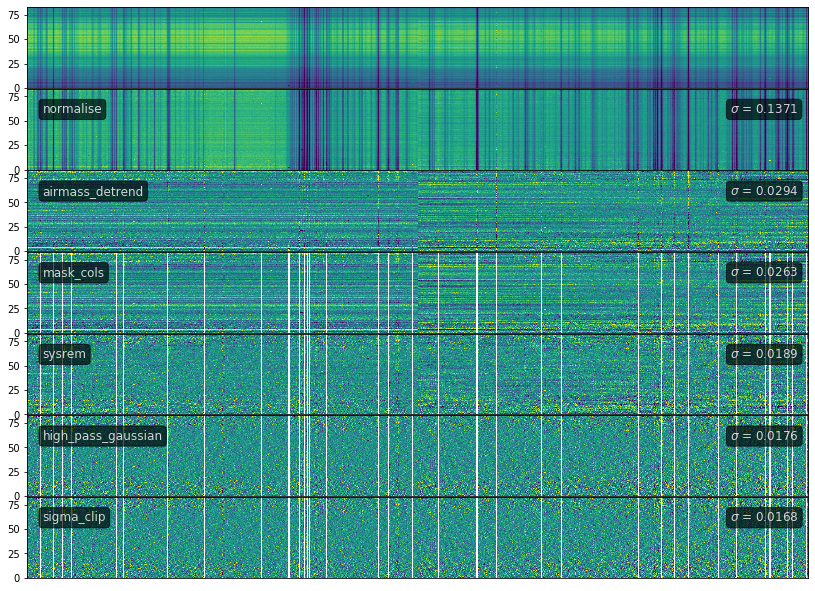

In [9]:
n = len(steps)+1
fig, ax = plt.subplots(n, figsize=(14, n*1.5))
plt.subplots_adjust(hspace=0.01)
[ax[k].set_xticks([]) for k in range(n)]

pipeline.reduce(dc.order(48), ax=ax)

Running the same reduction pipeline for GIANO seems to work fine, however, there is a clear *flux-jump* in the middle of the detector. This is one of GIANO quirks, **each order spans two detectors**, hence the flux sensitivity of each is different. To deal with this, the reduction of GIANO is performed on *half-orders*. After the reduction, all the half-orders will be merged just as in the previous Tutorial.

In [10]:
# Divide each order in two new *half-orders*
dc = dc.split_orders(debug=True) # most functions have a `debug=True` option to return some sanity-checks

(50, 84, 2048)
(100, 84, 1024)


The new datacube has doubled in the order-dimension. Now let's reduce the **first half of order 48**, which in the *new* index formatting will be **order = 48 x 2 = 96**. In addition, we'll add a new reduction step 

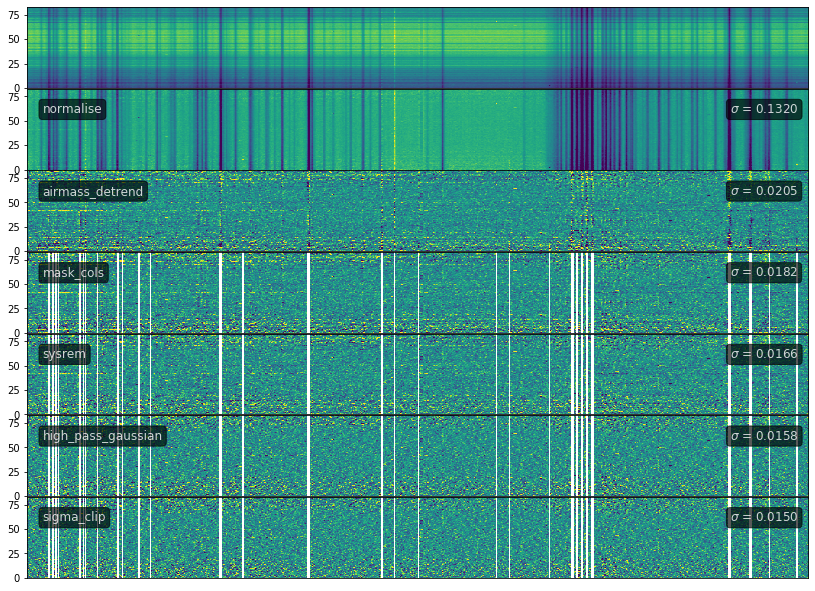

In [11]:
n = len(steps)+1
fig, ax = plt.subplots(n, figsize=(14, n*1.5))
plt.subplots_adjust(hspace=0.01)
[ax[k].set_xticks([]) for k in range(n)]

pipeline.reduce(dc.order(96), ax=ax)

#### Comparing two reduction pipelines
Let's create another set of reduction steps (`new_pipeline`) for GIANO and compare it to our first `pipeline`.

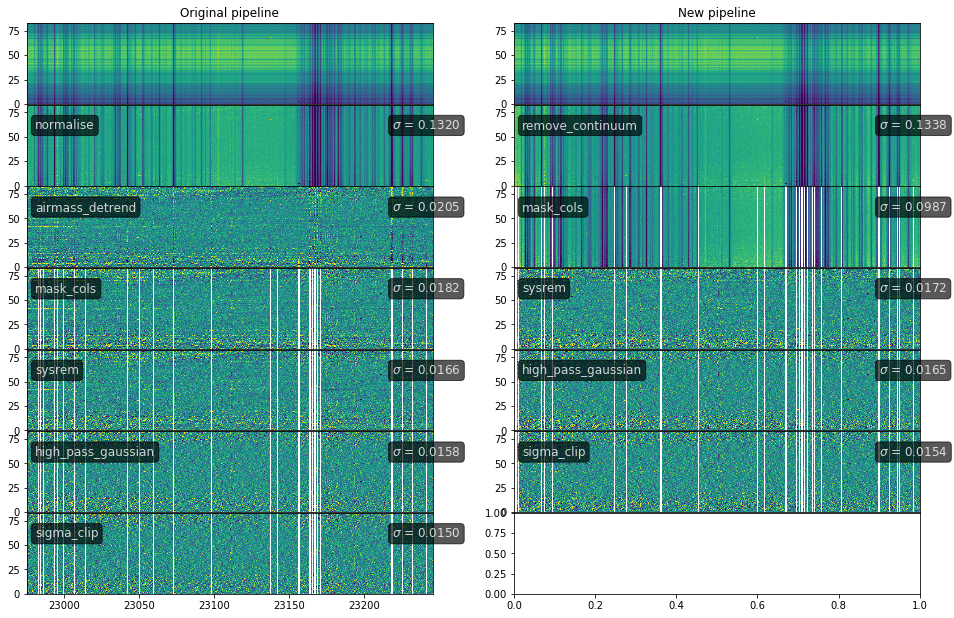

In [12]:
new_pipeline = Pipeline(steps=[])
new_pipeline.add('remove_continuum') # Now let's subtract the continuum by dividing by a polynomial fit
# new_pipeline.add('airmass_detrend') # Skip this step now
# Add functions with arguments
new_pipeline.add('mask_cols', {'sigma':1.2, 'mode':'flux'}) 
new_pipeline.add('sysrem', {'n':3}) # same number of sysrem iterations (analog to SVD modes)
new_pipeline.add('high_pass_gaussian', {'window':15})
new_pipeline.add('sigma_clip', {'sigma':3}) 

n = max(len(pipeline.steps), len(new_pipeline.steps)) + 1
fig, ax = plt.subplots(n, 2, figsize=(16, n*1.5))
plt.subplots_adjust(hspace=0.01)
[ax[k,l].set_xticks([]) for k in range(n-1) for l in range(2)]

titles = ['Original', 'New']
for col, pipe in enumerate([pipeline, new_pipeline]):
    pipe.reduce(dc.order(96), ax=ax[:,col])
    ax[0,col].set_title('{:} pipeline'.format(titles[col]))

plt.show()